In [1]:
from google.colab import drive
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support

In [2]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
csv_data = pd.read_csv('/content/drive/MyDrive/data/pmi-data.csv')

print(csv_data.describe())
csv_data.head()

                 id       gender          age  hypertension  heart_disease  \
count   3566.000000  3566.000000  3566.000000   3566.000000    3566.000000   
mean   36785.750701     1.394279    48.853898      0.125070       0.063937   
std    21239.999608     0.489337    18.874375      0.330845       0.244675   
min       67.000000     0.000000    10.000000      0.000000       0.000000   
25%    18042.750000     1.000000    34.000000      0.000000       0.000000   
50%    37448.500000     1.000000    50.000000      0.000000       0.000000   
75%    54984.250000     2.000000    63.000000      0.000000       0.000000   
max    72915.000000     2.000000    82.000000      1.000000       1.000000   

       ever_married    work_type  Residence_type  avg_glucose_level  \
count   3566.000000  3566.000000     3566.000000        3566.000000   
mean       0.759955     3.424846        0.491307         108.982011   
std        0.427170     0.894640        0.499995          48.292204   
min        0.

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,split
0,9046,2,67.0,0,1,1,4,0,228.69,36.6,1,1,test
1,51676,1,61.0,0,0,1,3,1,202.21,29.1,2,1,train
2,31112,2,80.0,0,1,1,4,1,105.92,32.5,2,1,train
3,60182,1,49.0,0,0,1,4,0,171.23,34.4,0,1,train
4,1665,1,79.0,1,0,1,3,1,174.12,24.0,2,1,train


In [6]:
X_train = csv_data[csv_data['split'] == 'train'].drop(columns=['split', 'stroke'])
y_train = csv_data[csv_data['split'] == 'train']['stroke']
X_test = csv_data[csv_data['split'] == 'test'].drop(columns=['split', 'stroke'])
y_test = csv_data[csv_data['split'] == 'test']['stroke']
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, shuffle=True, random_state=17)

print(X_train.describe())
print(y_train.describe())
print(X_test.describe())
print(y_test.describe())
print(X_val.describe())
print(y_val.describe())

# X_train.head()
# y_train.head()
# X_test.head()
# y_test.head()
# X_val.head()
# y_val.head()

train_num_positives = y_train.sum()
train_num_negatives = y_train.shape[0] - train_positives
train_ratio = train_num_negatives / train_num_positives

print(f'Train Dataset Imbalance: {train_num_positives}, {train_num_negatives}, Ratio: {train_ratio}')

                 id       gender          age  hypertension  heart_disease  \
count   2139.000000  2139.000000  2139.000000   2139.000000    2139.000000   
mean   36897.204769     1.391772    48.820009      0.131837       0.067789   
std    21212.797319     0.489217    18.932919      0.338393       0.251442   
min       67.000000     0.000000    10.000000      0.000000       0.000000   
25%    18248.500000     1.000000    34.000000      0.000000       0.000000   
50%    37349.000000     1.000000    50.000000      0.000000       0.000000   
75%    55556.000000     2.000000    63.000000      0.000000       0.000000   
max    72882.000000     2.000000    82.000000      1.000000       1.000000   

       ever_married    work_type  Residence_type  avg_glucose_level  \
count   2139.000000  2139.000000     2139.000000        2139.000000   
mean       0.767181     3.437120        0.487611         108.984175   
std        0.422727     0.885992        0.499963          48.771008   
min        0.

Why splitting the dataset into a train and validation set is good practice:
- it prevents overfitting, if we train and evaluate models on same data they might simply memorize the outputs
- by providing the model with data it has never seen during the training phase, we can ensure that it is able to generalize
- the validation data should be large enough to give a clear evaluation of the model's ability to generalize, but not too much, as that would leave insufficient data for training


In [7]:
class StrokeDataset(Dataset):
  def __init__(self, X, y):
    self.X = torch.tensor(X.values, dtype=torch.float32)
    self.y = torch.tensor(y.values, dtype=torch.float32)
    self.length = self.X.shape[0]

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]

  def __len__(self):
    return self.length

train_dataset = StrokeDataset(X_train, y_train)
test_dataset = StrokeDataset(X_test, y_test)
val_dataset = StrokeDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [8]:
class NeuralNetwork(nn.Module):
  def __init__(self, input_size, hidden_sizes, output_size):
    super(NeuralNetwork, self).__init__()

    if (hidden_sizes is None) or len(hidden_sizes) == 0:
      raise ValueError('hidden_sizes is None or empty')

    layers = []
    layers.append(nn.Linear(input_size, hidden_sizes[0]))
    for idx in range(1, len(hidden_sizes)):
      layers.append(nn.ReLU())
      layers.append(nn.Linear(hidden_sizes[idx - 1], hidden_sizes[idx]))

    layers.append(nn.ReLU())
    layers.append(nn.Linear(hidden_sizes[-1], output_size))
    # layers.append(nn.Sigmoid())

    self.layers = nn.ModuleList(layers)

  def forward(self, X):
    for layer in self.layers:
      X = layer(X)
    return X

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model0 = NeuralNetwork(input_size=X_train.shape[1], hidden_sizes=[16, 16], output_size=1)
model0.to(device)

model1 = NeuralNetwork(input_size=X_train.shape[1], hidden_sizes=[16, 16], output_size=1)
model1.to(device)

model2 = NeuralNetwork(input_size=X_train.shape[1], hidden_sizes=[16, 16], output_size=1)
model2.to(device)

for param in model0.parameters():
  print(param.shape)

torch.Size([16, 11])
torch.Size([16])
torch.Size([16, 16])
torch.Size([16])
torch.Size([1, 16])
torch.Size([1])


In [12]:
def train(model, sigmoid_threshold, loss_function, epochs, learning_rate):

  optimizer = optim.Adam(model.parameters(), lr=learning_rate)
  # loss_function = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([train_ratio]).to(device))

  train_epoch_losses = []
  train_epoch_accuracies = []

  val_epoch_losses = []
  val_epoch_accuracies = []

  val_predictions = []
  val_labels = []

  for epoch in range(epochs):
    model.train()

    train_current_epoch_loss = 0.0
    train_current_epoch_correct_predictions = 0
    train_current_epoch_total_predictions = 0

    for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
      X_batch = X_batch.to(device)
      y_batch = y_batch.to(device)

      optimizer.zero_grad()
      outputs = model(X_batch)
      loss = loss_function(outputs.view(-1), y_batch)
      loss.backward()
      optimizer.step()

      train_current_epoch_loss += loss.item()

      predictions = (torch.sigmoid(outputs) > sigmoid_threshold).float()
      train_current_epoch_correct_predictions += (predictions == y_batch).sum().item()
      train_current_epoch_total_predictions += y_batch.size(0)

    train_current_epoch_avg_loss = train_current_epoch_loss / len(train_loader)
    train_current_epoch_accuracy = train_current_epoch_correct_predictions / train_current_epoch_total_predictions

    train_epoch_losses.append(train_current_epoch_avg_loss)
    train_epoch_accuracies.append(train_current_epoch_accuracy)

    print(f'Training, Epoch {epoch + 1}/{epochs}, Loss: {train_current_epoch_avg_loss}, Accuracy: {train_current_epoch_accuracy}')

    model.eval()

    val_current_epoch_loss = 0.0
    val_current_epoch_correct_predictions = 0
    val_current_epoch_total_predictions = 0

    val_predictions = []
    val_labels = []

    with torch.no_grad():
      for batch_idx, (X_batch, y_batch) in enumerate(val_loader):
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        outputs = model(X_batch)
        loss = loss_function(outputs.view(-1), y_batch)

        val_current_epoch_loss += loss.item()

        predictions = (torch.sigmoid(outputs) > sigmoid_threshold).float()
        val_current_epoch_correct_predictions += (predictions == y_batch).sum().item()
        val_current_epoch_total_predictions += y_batch.size(0)

        val_predictions.extend(predictions.cpu().numpy())
        val_labels.extend(y_batch.cpu().numpy())

      val_current_epoch_avg_loss = val_current_epoch_loss / len(val_loader)
      val_current_epoch_accuracy = val_current_epoch_correct_predictions / val_current_epoch_total_predictions

      val_epoch_losses.append(val_current_epoch_avg_loss)
      val_epoch_accuracies.append(val_current_epoch_accuracy)

      print(f'Validation, Epoch {epoch + 1}/{epochs}, Loss: {val_current_epoch_avg_loss}, Accuracy: {val_current_epoch_accuracy}')

  return train_epoch_losses, train_epoch_accuracies, val_epoch_losses, val_epoch_accuracies, val_predictions, val_labels

In [15]:
def plot_results(train_epoch_losses, train_epoch_accuracies, val_epoch_losses, val_epoch_accuracies, val_predictions, val_labels):

  plt.figure(figsize=(12, 6))

  plt.subplot(1, 2, 1)
  plt.plot(train_epoch_losses, label='Training Loss', color='blue')
  plt.plot(val_epoch_losses, label='Validation Loss', color='red')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training and Validation Losses')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(train_epoch_accuracies, label='Training Accuracy', color='blue')
  plt.plot(val_epoch_accuracies, label='Validation Accuracy', color='red')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.title('Training and Validation Accuracies')
  plt.legend()

  plt.tight_layout()
  plt.show()

  val_predictions = np.array(val_predictions).reshape(-1)
  val_labels = np.array(val_labels).reshape(-1)

  conf_matrix = confusion_matrix(val_labels, val_predictions)

  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Stroke', 'Stroke'], yticklabels=['No Stroke', 'Stroke'])

  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.title('Confusion Matrix')

  plt.show()

  precision, recall, f1_score, _ = precision_recall_fscore_support(val_labels, val_predictions, average='binary')

  print(f'Precision: {precision}')
  print(f'Recall: {recall}')
  print(f'F1 Score: {f1_score}')

Training, Epoch 1/100, Loss: 231.32628381602905, Accuracy: 34.28845254791959
Validation, Epoch 1/100, Loss: 26.911308725674946, Accuracy: 60.074333800841515
Training, Epoch 2/100, Loss: 27.881903712802075, Accuracy: 60.049555867227674
Validation, Epoch 2/100, Loss: 19.395301342010498, Accuracy: 60.074333800841515
Training, Epoch 3/100, Loss: 13.537130797610564, Accuracy: 60.049555867227674
Validation, Epoch 3/100, Loss: 3.698682771788905, Accuracy: 60.074333800841515
Training, Epoch 4/100, Loss: 1.4938731271883143, Accuracy: 57.35063113604488
Validation, Epoch 4/100, Loss: 1.8785713301234257, Accuracy: 60.074333800841515
Training, Epoch 5/100, Loss: 1.5277835736051202, Accuracy: 57.20149602618046
Validation, Epoch 5/100, Loss: 1.261886790394783, Accuracy: 60.074333800841515
Training, Epoch 6/100, Loss: 0.5658689075533081, Accuracy: 58.641421224871436
Validation, Epoch 6/100, Loss: 0.3538772736986478, Accuracy: 60.074333800841515
Training, Epoch 7/100, Loss: 1.120976082761498, Accuracy:

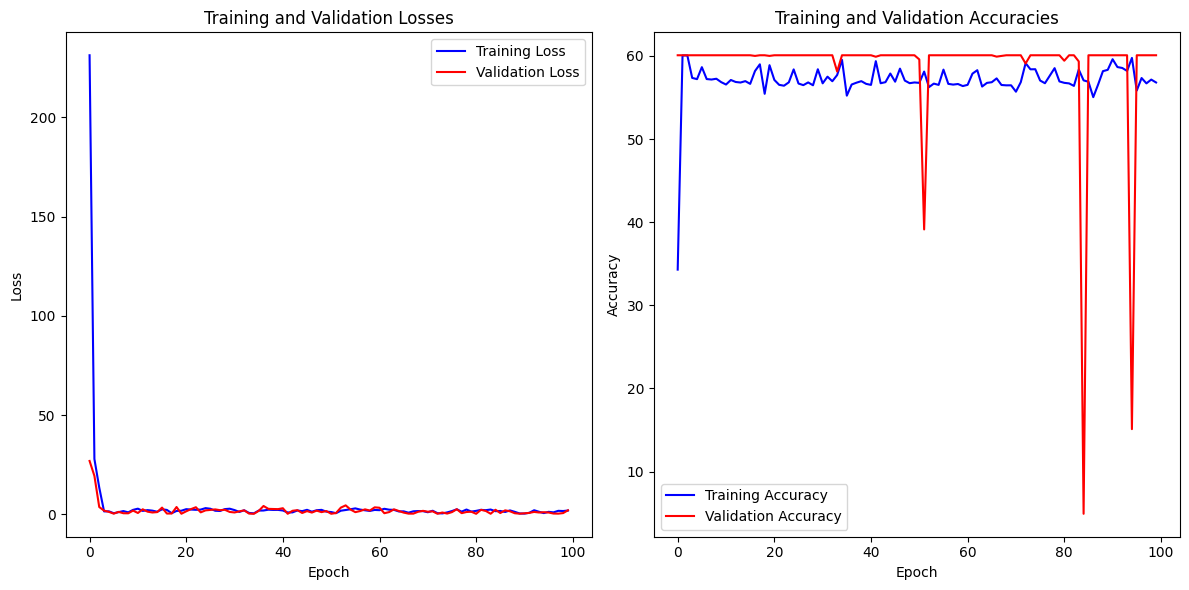

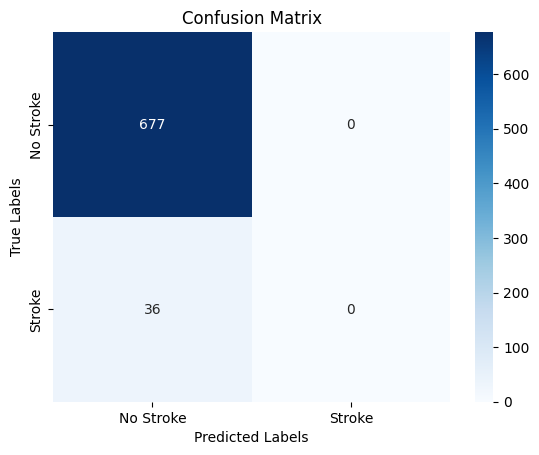

Precision: 0.0
Recall: 0.0
F1 Score: 0.0


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [20]:
train_epoch_losses, train_epoch_accuracies, val_epoch_losses, val_epoch_accuracies, val_predictions, val_labels = train(model0, 0.5, nn.BCEWithLogitsLoss(), 100, 0.001)

plot_results(train_epoch_losses, train_epoch_accuracies, val_epoch_losses, val_epoch_accuracies, val_predictions, val_labels)